In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader

In [ ]:
data_transforms = {
    'train': transforms.Compose([
        transforms.ToTensor()
    ]),
    'val': transforms.Compose([
        transforms.ToTensor()
    ]),
}

In [4]:
image_datasets = {
    'train': datasets.ImageFolder('Final_Data/Train', data_transforms['train']),
    'val': datasets.ImageFolder('Final_Data/Validation', data_transforms['val'])
}

In [5]:
dataloaders = {
    'train': DataLoader(image_datasets['train'], batch_size=32, shuffle=True, num_workers=4),
    'val': DataLoader(image_datasets['val'], batch_size=32, shuffle=False, num_workers=4)
}

In [6]:
class ASLClassifierCNN(nn.Module):
    def __init__(self, num_classes):
        super(ASLClassifierCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(128 * 32 * 32, 512)
        self.fc2 = nn.Linear(512, num_classes)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = self.pool(x)
        x = torch.relu(self.conv2(x))
        x = self.pool(x)
        x = torch.relu(self.conv3(x))
        x = self.pool(x)
        x = x.view(x.size(0), -1)  # Flatten
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

# Instantiate model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ASLClassifierCNN(num_classes=27).to(device)

In [7]:

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

Training with hyperparameters: {'num_classes': 27, 'learning_rate': 0.001, 'batch_size': 32}
Epoch 1/10
--------------------
Train Batch 1/175 - Loss: 3.3077, Accuracy: 0.0000
Train Batch 2/175 - Loss: 3.8086, Accuracy: 0.0625
Train Batch 3/175 - Loss: 3.5011, Accuracy: 0.0312
Train Batch 4/175 - Loss: 3.4662, Accuracy: 0.0312
Train Batch 5/175 - Loss: 3.3253, Accuracy: 0.0312
Train Batch 6/175 - Loss: 3.3061, Accuracy: 0.0312
Train Batch 7/175 - Loss: 3.2819, Accuracy: 0.0000
Train Batch 8/175 - Loss: 3.2791, Accuracy: 0.1250
Train Batch 9/175 - Loss: 3.2856, Accuracy: 0.0312
Train Batch 10/175 - Loss: 3.3151, Accuracy: 0.0625
Train Batch 11/175 - Loss: 3.2913, Accuracy: 0.0312
Train Batch 12/175 - Loss: 3.3328, Accuracy: 0.0000
Train Batch 13/175 - Loss: 3.3232, Accuracy: 0.0312
Train Batch 14/175 - Loss: 3.2899, Accuracy: 0.0625
Train Batch 15/175 - Loss: 3.2938, Accuracy: 0.0312
Train Batch 16/175 - Loss: 3.2957, Accuracy: 0.0312
Train Batch 17/175 - Loss: 3.2909, Accuracy: 0.0312


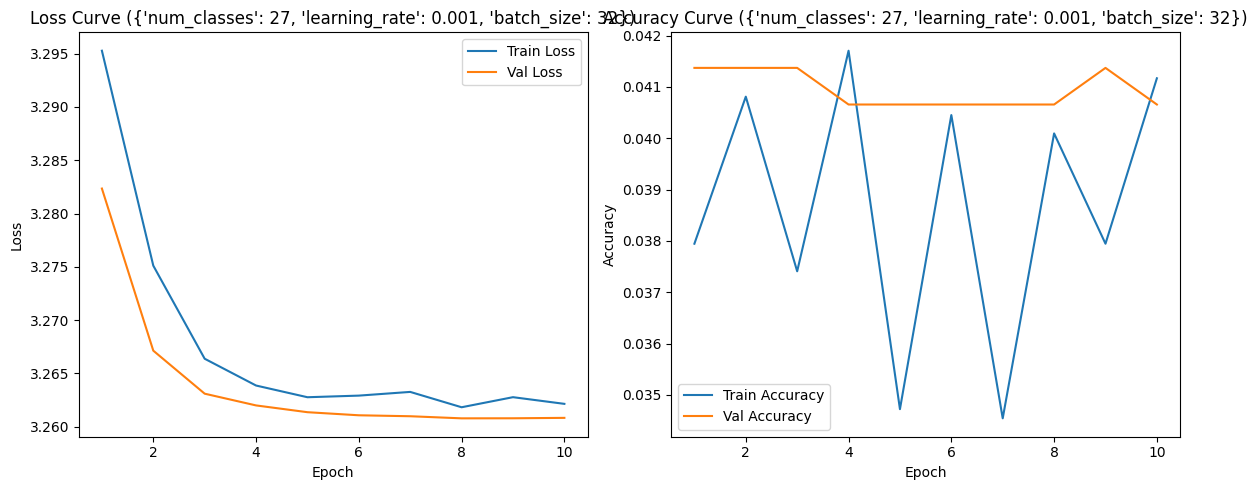

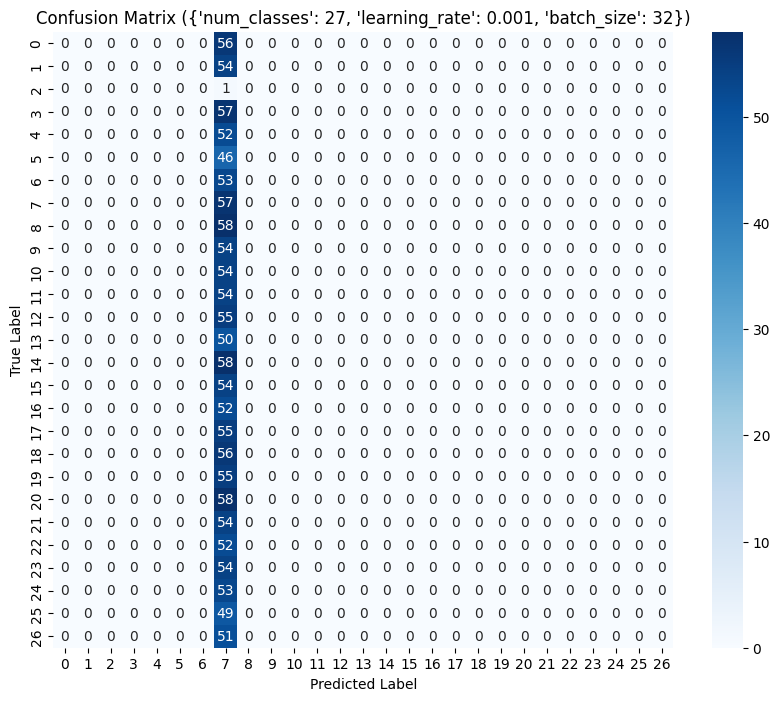

Training with hyperparameters: {'num_classes': 27, 'learning_rate': 0.0005, 'batch_size': 64}
Epoch 1/10
--------------------
Train Batch 1/88 - Loss: 3.2989, Accuracy: 0.0469
Train Batch 2/88 - Loss: 3.4808, Accuracy: 0.0781
Train Batch 3/88 - Loss: 3.5385, Accuracy: 0.0312
Train Batch 4/88 - Loss: 3.3077, Accuracy: 0.0625
Train Batch 5/88 - Loss: 3.2925, Accuracy: 0.0312
Train Batch 6/88 - Loss: 3.3531, Accuracy: 0.0156
Train Batch 7/88 - Loss: 3.2756, Accuracy: 0.0625
Train Batch 8/88 - Loss: 3.2924, Accuracy: 0.0156
Train Batch 9/88 - Loss: 3.2938, Accuracy: 0.0312
Train Batch 10/88 - Loss: 3.2878, Accuracy: 0.0469
Train Batch 11/88 - Loss: 3.3091, Accuracy: 0.0312
Train Batch 12/88 - Loss: 3.2872, Accuracy: 0.0312
Train Batch 13/88 - Loss: 3.2881, Accuracy: 0.0469
Train Batch 14/88 - Loss: 3.2684, Accuracy: 0.0781
Train Batch 15/88 - Loss: 3.2740, Accuracy: 0.0156
Train Batch 16/88 - Loss: 3.2481, Accuracy: 0.0625
Train Batch 17/88 - Loss: 3.2436, Accuracy: 0.0469
Train Batch 18/8

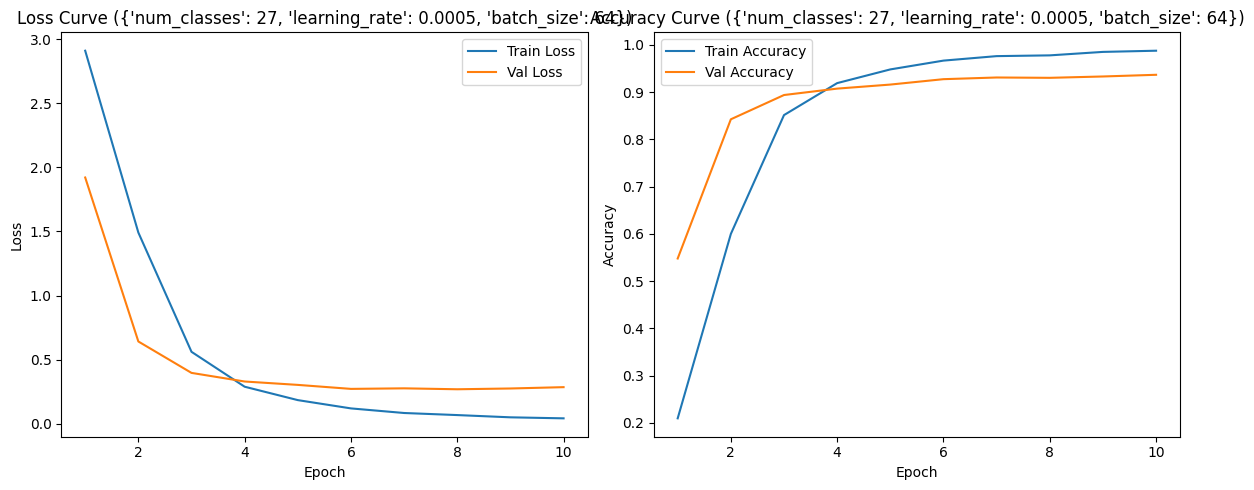

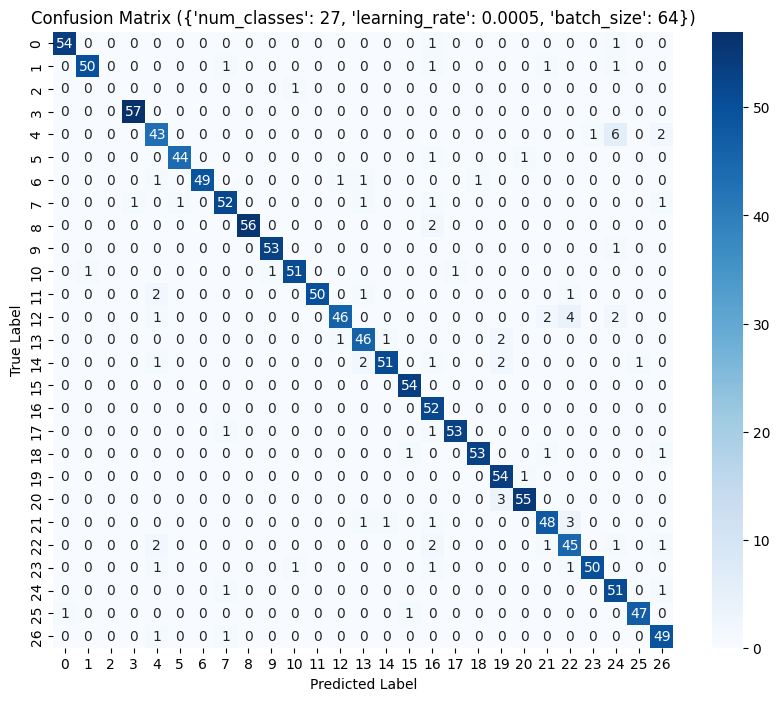

Training with hyperparameters: {'num_classes': 27, 'learning_rate': 0.005, 'batch_size': 16}
Epoch 1/10
--------------------
Train Batch 1/350 - Loss: 3.2872, Accuracy: 0.0625
Train Batch 2/350 - Loss: 115.6583, Accuracy: 0.0625
Train Batch 3/350 - Loss: 21.1663, Accuracy: 0.0000
Train Batch 4/350 - Loss: 3.3284, Accuracy: 0.0000
Train Batch 5/350 - Loss: 4.2426, Accuracy: 0.0000
Train Batch 6/350 - Loss: 3.8286, Accuracy: 0.0000
Train Batch 7/350 - Loss: 3.2803, Accuracy: 0.1250
Train Batch 8/350 - Loss: 3.3535, Accuracy: 0.0625
Train Batch 9/350 - Loss: 3.3262, Accuracy: 0.0000
Train Batch 10/350 - Loss: 3.3168, Accuracy: 0.0000
Train Batch 11/350 - Loss: 3.2804, Accuracy: 0.0000
Train Batch 12/350 - Loss: 3.2938, Accuracy: 0.0000
Train Batch 13/350 - Loss: 3.2296, Accuracy: 0.0625
Train Batch 14/350 - Loss: 3.3318, Accuracy: 0.0000
Train Batch 15/350 - Loss: 3.3993, Accuracy: 0.0625
Train Batch 16/350 - Loss: 3.2569, Accuracy: 0.1875
Train Batch 17/350 - Loss: 3.3289, Accuracy: 0.00

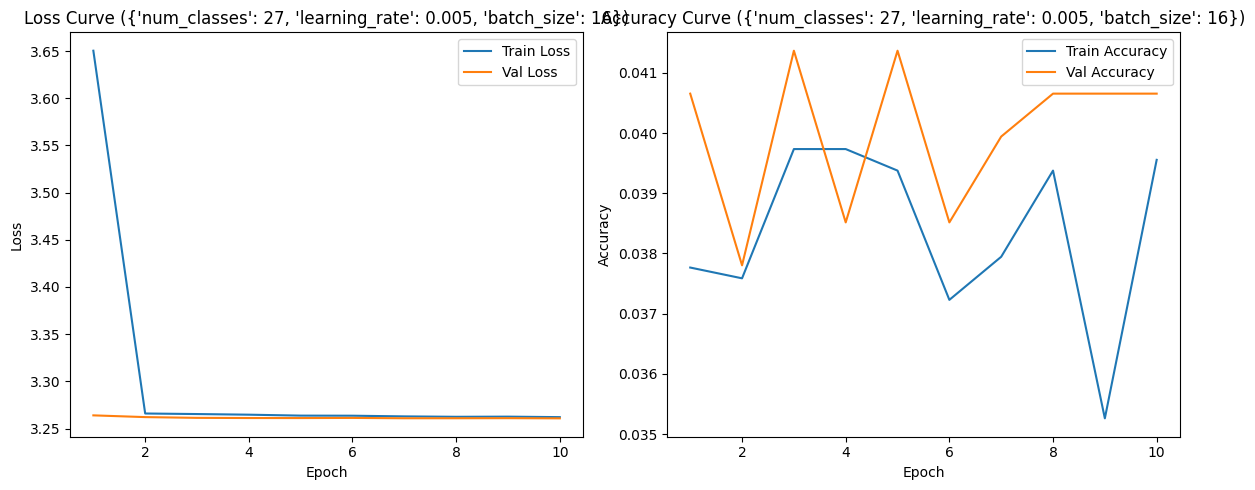

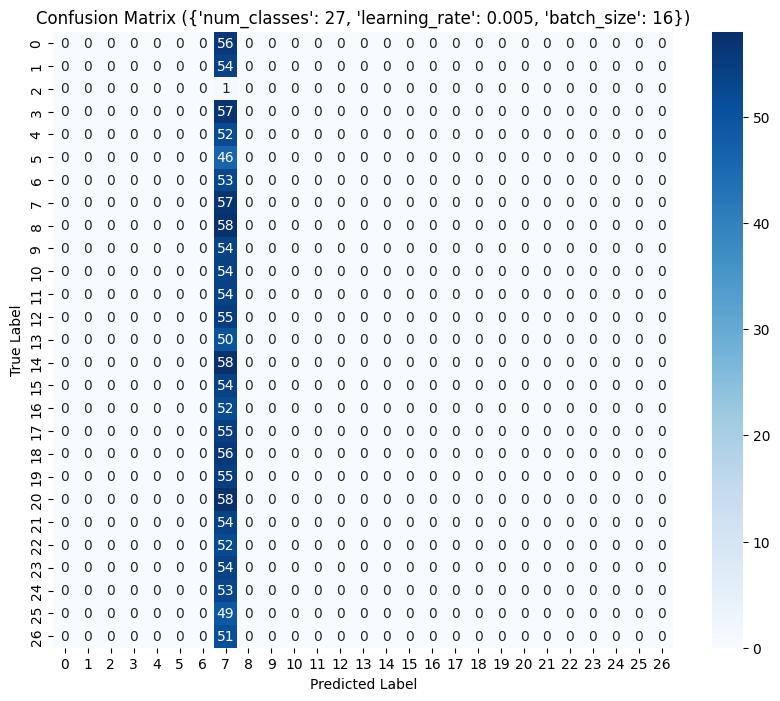

All configurations completed!
                                              config  train_loss  val_loss  \
0  {'num_classes': 27, 'learning_rate': 0.001, 'b...    3.262152  3.260838   
1  {'num_classes': 27, 'learning_rate': 0.0005, '...    0.043845  0.286874   
2  {'num_classes': 27, 'learning_rate': 0.005, 'b...    3.262069  3.260790   

   train_acc   val_acc  
0   0.041167  0.040656  
1   0.987471  0.936519  
2   0.039556  0.040656  


In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import confusion_matrix
import seaborn as sns

def train_and_plot_hyperparameter_effects(hyperparameters, image_datasets, num_epochs=10):
    """
    Trains the model with different hyperparameter combinations and plots results.

    Args:
        hyperparameters (list of dict): List of hyperparameter dictionaries.
        image_datasets (dict): Datasets for 'train' and 'val' datasets.
        num_epochs (int): Number of epochs for each training run.

    Returns:
        pd.DataFrame: A DataFrame with hyperparameter configurations and corresponding results.
    """
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    results = []

    for config in hyperparameters:
        print(f"Training with hyperparameters: {config}")
        num_classes = config.get('num_classes', 27)
        learning_rate = config.get('learning_rate', 0.001)
        batch_size = config.get('batch_size', 32)

        # Initializing the model to be trained using the parameters
        model = ASLClassifierCNN(num_classes=num_classes).to(device)
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(model.parameters(), lr=learning_rate)

        # Make the dataloaders
        dataloaders = {
            'train': DataLoader(image_datasets['train'], batch_size=batch_size, shuffle=True, num_workers=4),
            'val': DataLoader(image_datasets['val'], batch_size=batch_size, shuffle=False, num_workers=4)
        }

        train_losses, val_losses = [], []
        train_accs, val_accs = [], []
        best_val_acc = 0.0

        for epoch in range(num_epochs):
            print(f"Epoch {epoch+1}/{num_epochs}")
            print('-' * 20)

            for phase in ['train', 'val']:
                if phase == 'train':
                    model.train()
                else:
                    model.eval()

                running_loss = 0.0
                running_corrects = 0
                total_samples = 0
                all_preds = []
                all_labels = []

                for i, (inputs, labels) in enumerate(dataloaders[phase]):
                    inputs, labels = inputs.to(device), labels.to(device)
                    optimizer.zero_grad()
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)

                        if phase == 'train':
                            loss.backward()
                            optimizer.step()
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)
                    total_samples += labels.size(0)

                    batch_loss = loss.item()
                    batch_acc = torch.sum(preds == labels.data).double() / labels.size(0)
                    print(f"{phase.capitalize()} Batch {i+1}/{len(dataloaders[phase])} - Loss: {batch_loss:.4f}, Accuracy: {batch_acc:.4f}")

                    all_preds.extend(preds.cpu().numpy())
                    all_labels.extend(labels.cpu().numpy())

                epoch_loss = running_loss / len(image_datasets[phase])
                epoch_acc = running_corrects.double() / total_samples

                if phase == 'train':
                    train_losses.append(epoch_loss)
                    train_accs.append(epoch_acc.item())
                else:
                    val_losses.append(epoch_loss)
                    val_accs.append(epoch_acc.item())

                    # Check if the model improved
                    if epoch_acc > best_val_acc:
                        best_val_acc = epoch_acc
                        torch.save(model.state_dict(), 'best_model.pth')
                        print(f"Saved model on {epoch+1}")

                print(f"{phase.capitalize()} Epoch Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}")

        # Save results for this configuration
        results.append({
            'config': config,
            'train_loss': train_losses[-1],
            'val_loss': val_losses[-1],
            'train_acc': train_accs[-1],
            'val_acc': val_accs[-1]
        })
        plt.figure(figsize=(12, 5))

        # Loss Curve
        plt.subplot(1, 2, 1)
        plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss')
        plt.plot(range(1, num_epochs + 1), val_losses, label='Val Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title(f"Loss Curve ({config})")
        plt.legend()
        # Accuracy Curve
        plt.subplot(1, 2, 2)
        plt.plot(range(1, num_epochs + 1), train_accs, label='Train Accuracy')
        plt.plot(range(1, num_epochs + 1), val_accs, label='Val Accuracy')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.title(f"Accuracy Curve ({config})")
        plt.legend()
        plt.tight_layout()
        plt.show()

        if len(all_preds) > 0 and len(all_labels) > 0:
            cm = confusion_matrix(all_labels, all_preds)
            plt.figure(figsize=(10, 8))
            sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
            plt.xlabel('Predicted Label')
            plt.ylabel('True Label')
            plt.title(f'Confusion Matrix ({config})')
            plt.show()

    # Convert results to a DataFrame for further analysis
    results_df = pd.DataFrame(results)
    print("All configurations completed!")
    return results_df


# Example of hyperparameter configurations to test
hyperparameter_configs = [
    {'num_classes': 27, 'learning_rate': 0.001, 'batch_size': 64},
    {'num_classes': 27, 'learning_rate': 0.0005, 'batch_size': 64},
    {'num_classes': 27, 'learning_rate': 0.005, 'batch_size': 64},
]

# Run training and plot results
results_df = train_and_plot_hyperparameter_effects(hyperparameter_configs, image_datasets, num_epochs=10)

# Display summary results
print(results_df)